# 사진 가지고 오기

사용할 디렉터리 구조

- aiffel/human_segmentation
    ├── models
        └── deeplabv3_xception_tf_dim_ordering_tf_kernels.h5 (미리 준비할 필요는 없습니다)
    ├── images
        └── my_image.png   (사진 이름은 각자 파일명에 따라 다르게 사용하시면 됩니다)

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print('희희')

희희


사진준비

(960, 1440, 3)


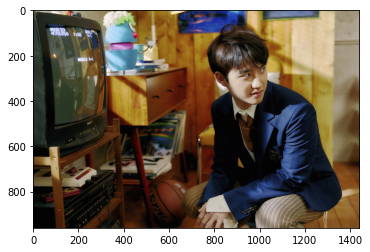

In [2]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
# 이미지파일 확장자명 주의❗
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpg'
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

**DeepLab 모델 준비**

**PixelLib에서 제공해 주는 모델을 다운로드**

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fb1303a2100>)

다운로드한 모델을 이용해 **PixelLib**로 우리가 사용할 세그멘테이션 모델을 생성

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

**모델에 이미지를 입력**

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path)

PASCAL VOC 데이터의 라벨 종류 🔽

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

모델에서 나온 출력값을 살짝 살펴보기😉

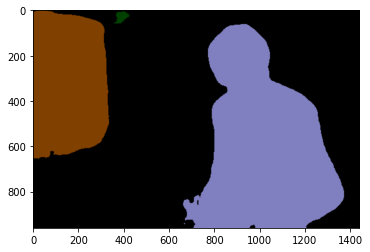

In [7]:
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0, 15, 16, 20]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
pottedplant
tv


output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있다.

segvalues에는 class_ids와 masks가 있고, class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있다.

이제 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내면 될 것 같아😎

In [10]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

PixelLib에 따르면 위와 같은 색을 사용했다고 나온다.

그럼 사람을 나타내는 15번째 색상은 뭘까?

In [11]:
colormap[15]

array([192, 128, 128])

사람 외에도 다른 물체를 찾아내고 싶다면 colormap[class_id]처럼 찾아낼 수 있다.

여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점, colormap은 RGB 순서이다❗

그러니 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야한다.

In [12]:
seg_color = (128,128,192)

이제 seg_color로만 이루어진 마스크를 만들어 보자

(960, 1440)


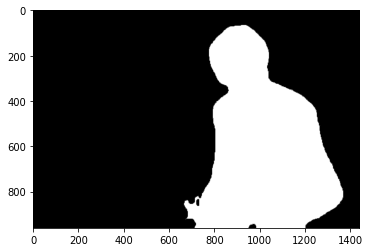

In [13]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

3채널 가졌던 원본과는 다르게 채널 정보가 사라졌고,

아래처럼 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 되었다.

원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 알아보기 쉽다.😁

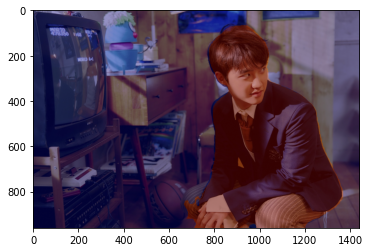

In [14]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 배경 흐리게 만들기

**blur()** 함수 이용

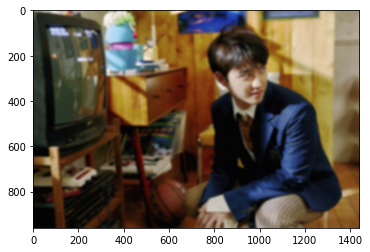

In [15]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

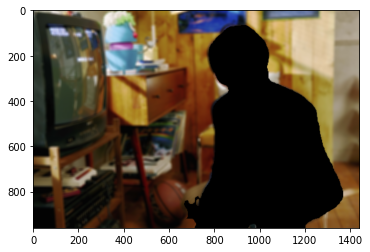

In [16]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 배경 영상과 사람 영상 합치기

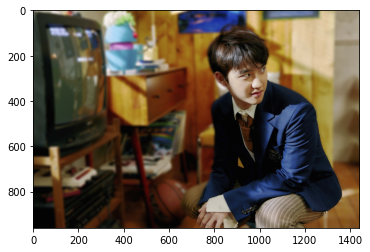

In [17]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

사진기준 오른쪽 팔이 블러처리 되었음

# 고양이 사진

(1080, 1440, 3)


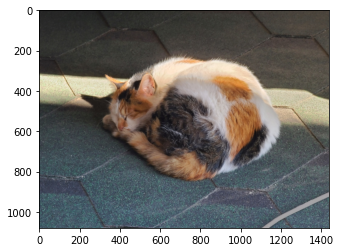

In [18]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
# 이미지파일 확장자명 주의❗
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/고양이.jpg'
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

PixelLib에서 모델 다운로드

In [19]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fb0d68ae1c0>)

**PixelLib**로 우리가 사용할 세그멘테이션 모델을 생성

In [20]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

모델 이미지 입력

In [21]:
segvalues, output = model.segmentAsPascalvoc(img_path)

PASCAL VOC 데이터의 라벨 종류

In [22]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

모델에서 나온 출력값 살펴보기

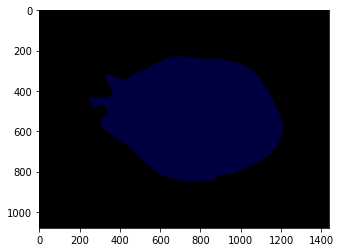

In [23]:
plt.imshow(output)
plt.show()

In [24]:
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [25]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


물체마다 output에 어떤 색상으로 나타나 있는지 확인

In [26]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [27]:
# 고양이를 나타내는 8번째 색상
colormap[8]

array([64,  0,  0])

In [28]:
seg_color = (0,0,64)

seg_color로만 이루어진 마스크 만들기

(1080, 1440)


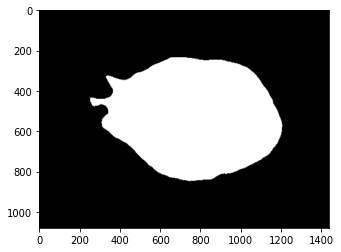

In [29]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

왜... 흑백만 나오지?

▶ 코드를 잘못 입력했었음

원래 이미지와 겹쳐서 세그멘테이션이 얼마나 잘 되었는지 확인

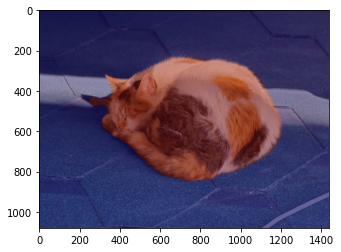

In [30]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 배경 흐리게 만들기

**blur()** 함수 이용

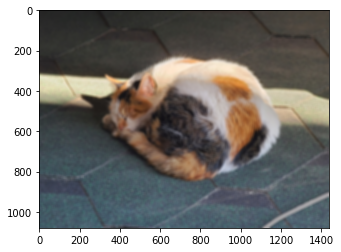

In [31]:
# (15,15)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (15,15))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

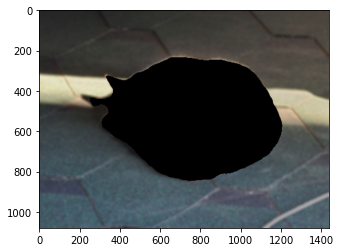

In [32]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 배경 영상과 고양이 영상 합치기

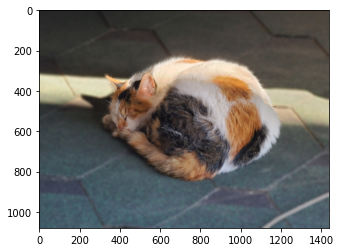

In [33]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 배경전환 크로마키

In [34]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
# 이미지파일 확장자명 주의❗
bacground_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/유채꽃밭.jpeg'
bacground_img_orig = cv2.imread(bacground_img_path) 
print (bacground_img_orig.shape)

(480, 640, 3)


(895, 1280, 3)


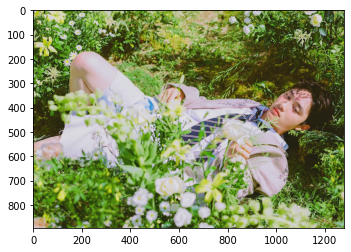

In [35]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
# 이미지파일 확장자명 주의❗
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/공감.png'
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

DeepLab 모델 준비

PixelLib에서 제공해 주는 모델을 다운로드

In [36]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fb0cfca2dc0>)

In [37]:
# 다운로드한 모델을 이용해 PixelLib로 사용할 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [38]:
# 모델 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

In [39]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

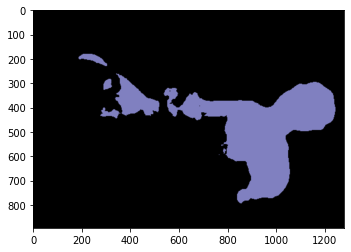

In [40]:
# 모델에서 나온 출력값 살펴보기
plt.imshow(output)
plt.show()

In [41]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [42]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [43]:
# 물체마다 output에 어떤 색상으로 나타나 있는지 확인
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [44]:
# 사람 15번째 색상 확인
colormap[15]

array([192, 128, 128])

In [45]:
seg_color = (128,128,192)

(895, 1280)


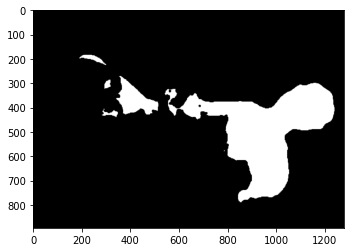

In [46]:
# seg_color로만 이루어진 마스크 만들기

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

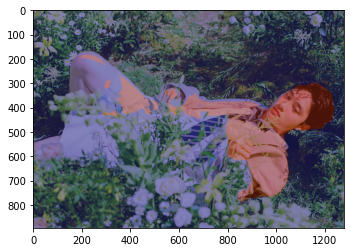

In [47]:
# 원래 이미지와 겹쳐서 세그멘테이션이 얼마나 잘 되었는지 확인
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

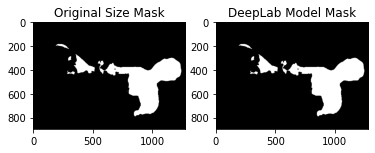

In [48]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

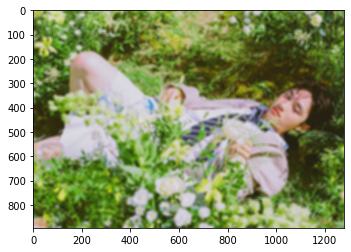

In [49]:
# 배경 흐리게 만들기
# blur() 함수 이용

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

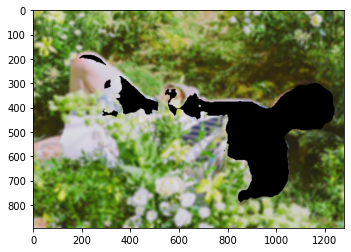

In [50]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 배경 영상과 사람 영상 합치기

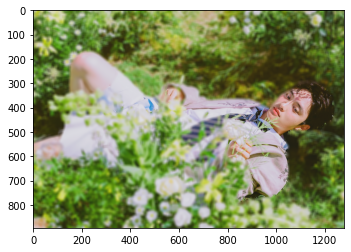

In [51]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

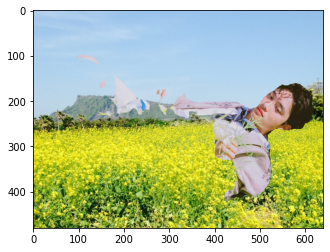

In [52]:
img_resized = cv2.resize(
    img_orig, (bacground_img_orig.shape[1], bacground_img_orig.shape[0]))
img_mask_resized = cv2.resize(
    img_mask_color, (bacground_img_orig.shape[1], bacground_img_orig.shape[0]))

img_background_concat = np.where(
    img_mask_resized == 255, img_resized, bacground_img_orig)

plt.imshow(cv2.cvtColor(img_background_concat, cv2.COLOR_BGR2RGB))
plt.show()

▶▶▶ 문제점 : 하체를 배경으로 인식하고 배경처리가 되었다.(유채꽃밭 이불을 덮은 모습을 확인할 수 있다.)

# [E-07] 회고

이번 exploration은 사진을 다루는 내용이여서 행복했습니다.🥰
저번에 사진에 스티커를 붙이는 exploration를 했었어서 노드의 내용이 조금 더 쉽게 잘 들어왔던 것 같습니다.

먼저 사람과 블러처리된 사진을 합치는 파트는 수월하게 잘 넘어갔습니다.
exploration 7번 노드만 잘 따라가면 되니까요.

하지만 고양이 사진과 배경 크로마키를 하는데 조금 난관이 있었는데요.

고양이 사진 파트를 할 때 mapcolor를 토대로 seg_color를 뽑았어야 했는데, 제가 노드에서 문장을 잘못 이해해서 오류가 난 것이었습니다.

그래서 고양이 코드인 '8'으로 고쳐주자 고양이 사진이 블러처리가 되어서 잘 나왔습니다.

그리고 대망의 크로마키... 크로마키는 배경을 어떻게 처리해야 할 지 몰랐는데, 노드를 자세히 보니 제가 링크를 하나 놓쳐서 못 본 게 있더라구요ㅎ

근데도 방법을 잘 몰라서 제가 자주 참고하는 깃허브를 참고했습니다.
https://github.com/JaeHeee/AIFFEL_Project/tree/master/EXPLORATION

배경을 정의하고 가져오는 방법을 가져와 사용해보니 잘 돌아갔는데😂
마지막 사진을 보시면ㅎㅎㅎ 하체부분을 사람으로 인식하지 못 해서 유채꽃밭 이불을 덮고 있는 모습이 나옵니다.😅

해결하는 깃허브에서는 픽셀을 조금씩 움직여서 마스크를 3개 만들어 배경과 합치는 방법을 말했는데, 이 방법으로는 경수(사진속 인물 이름)가 유채꽃밭 이불을 못 벗겠더라구요.

지금으로써 제가 어떻게 방법을 잘 못찾아서 과제를 제출하고 다른 분들은 어떻게 하셨나 물어보고 오답노트를 할 예정입니다.😅🥰